In [4]:
from ultralytics import YOLO
from PIL import Image
import requests
import io
import base64

# مرحله 1: بارگذاری مدل محلی و برش پلاک
image_path = "photos/test4.jpg"
model = YOLO("models/best.pt")  # مدل شما برای تشخیص پلاک
results = model(image_path)

# فرض: فقط یک پلاک در تصویر وجود دارد
if results[0].boxes:
    box = results[0].boxes.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
    x1, y1, x2, y2 = map(int, box)

    img = Image.open(image_path)
    plate_img = img.crop((x1, y1, x2, y2))

    # ذخیره موقت یا تبدیل به بایت
    buffered = io.BytesIO()
    plate_img.save(buffered, format="JPEG")
    img_bytes = buffered.getvalue()
else:
    raise Exception("پلاکی یافت نشد!")

# مرحله 2: ارسال تصویر برش‌خورده به Roboflow OCR
API_URL = "https://serverless.roboflow.com"
API_KEY = "6he8SqewRgItxAfDeC3O"
OCR_MODEL_ID = "platedetector-xoolc-mj108/1"  # جایگزین کنید با مدل OCR شما

# کدگذاری به base64
encoded_img = base64.b64encode(img_bytes).decode("utf-8")

# ارسال درخواست
response = requests.post(
    f"{API_URL}/{OCR_MODEL_ID}",
    headers={
        "Content-Type": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    },
    json={"image": encoded_img}
)

if response.status_code == 200:
    ocr_result = response.json()
    # خروجی دقیق بستگی به ساختار مدل OCR شما دارد
    print("نتیجه OCR از Roboflow:", ocr_result)
else:
    print("خطا در ارسال به Roboflow:", response.status_code, response.text)


image 1/1 E:\AI_PLPR_Last\PLPR\photos\test4.jpg: 640x480 1 plate, 103.8ms
Speed: 6.1ms preprocess, 103.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
خطا در ارسال به Roboflow: 401 {"status":401,"message":"Unauthorized api_key"}


In [6]:
from ultralytics import YOLO
from PIL import Image
import requests
import io
import base64

# ==============================
# Configuration – EDIT THESE!
# ==============================
image_path = "E:/AI_PLPR_Last/PLPR/photos/test4.jpg"  # Your input image
local_model_path = "E:/AI_PLPR_Last/PLPR/models/best.pt"                          # Your YOLO plate detector
ROBOFLOW_API_KEY = "6he8SqewRgItxAfDeC3O"             # ← Must be a valid Inference API Key
OCR_MODEL_ID = "platedetector-xoolc-mj108/1"                     # ← Replace with your OCR model ID
# ==============================

# Step 1: Detect plate using your local YOLO model
print("🔍 Detecting license plate with local model...")
model = YOLO(local_model_path)
results = model(image_path)

if not results[0].boxes:
    raise Exception("❌ No license plate detected in the image!")

# Get the first (and assumed only) plate bounding box
box = results[0].boxes.xyxy[0].cpu().numpy()  # [x1, y1, x2, y2]
x1, y1, x2, y2 = map(int, box)

# Crop the plate region
img = Image.open(image_path)
plate_img = img.crop((x1, y1, x2, y2))

# Optional: Save cropped plate for debugging
# plate_img.save("cropped_plate.jpg")

# Step 2: Convert cropped image to base64
buffered = io.BytesIO()
plate_img.save(buffered, format="JPEG")
img_bytes = buffered.getvalue()
encoded_img = base64.b64encode(img_bytes).decode("utf-8")

# Step 3: Send to Roboflow OCR model
print("📤 Sending cropped plate to Roboflow OCR...")
url = f"https://serverless.roboflow.com/{OCR_MODEL_ID}"
headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {ROBOFLOW_API_KEY}"
}
payload = {"image": encoded_img}

response = requests.post(url, json=payload, headers=headers)

# Step 4: Handle response
if response.status_code == 200:
    ocr_result = response.json()
    print("✅ OCR Result from Roboflow:")
    print(ocr_result)
    # Depending on your model, the text might be in:
    # - ocr_result['predictions'][0]['class']  (if classification)
    # - ocr_result['text']                     (if custom OCR model)
    # So inspect the structure first!
else:
    print(f"❌ Error: {response.status_code}")
    print(response.json())

🔍 Detecting license plate with local model...

image 1/1 E:\AI_PLPR_Last\PLPR\photos\test4.jpg: 640x480 1 plate, 105.8ms
Speed: 6.3ms preprocess, 105.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)
📤 Sending cropped plate to Roboflow OCR...
❌ Error: 401
{'status': 401, 'message': 'Unauthorized api_key'}


Loading models...

===== Processing: test1.jpg =====


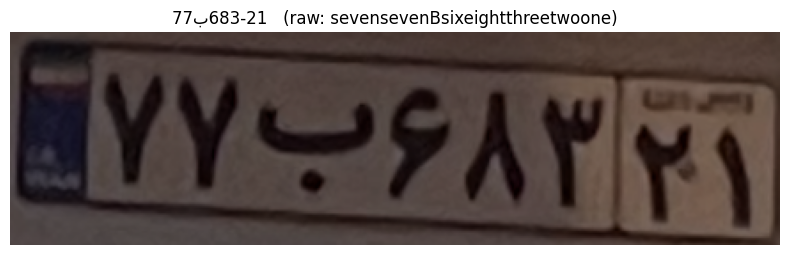

  Raw classes : sevensevenBsixeightthreetwoone
  Mapped text : 77ب68321
  Final clean : 77ب68321
  Standardized: 77ب683-21
  Conf        : 0.760
  → Saved as: test1_plate1_77ب683_21.jpg

===== Processing: test2.jpg =====


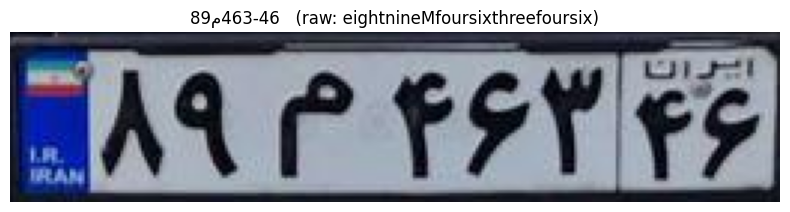

  Raw classes : eightnineMfoursixthreefoursix
  Mapped text : 89م46346
  Final clean : 89م46346
  Standardized: 89م463-46
  Conf        : 0.763
  → Saved as: test2_plate1_89م463_46.jpg

===== Processing: test3.jpg =====


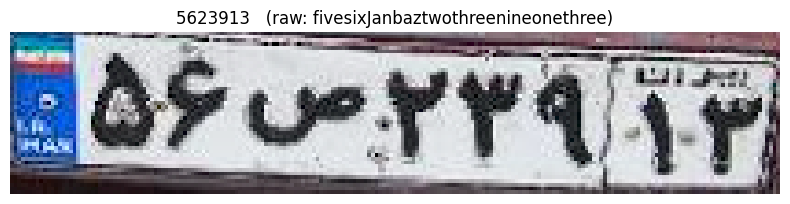

  Raw classes : fivesixJanbaztwothreenineonethree
  Mapped text : 5623913
  Final clean : 5623913
  Standardized: 5623913
  Conf        : 0.689
  → Saved as: test3_plate1_5623913.jpg

Processing complete ✓

